# Question 1. Is early plant growth related to crop performance?

Phosphorus dosage is known to increase starting biomass. This notebook explores if the starting biomass affecting performance. The statistical tool used is a linear mixed model.

Load data exported from the preprossing session.

In [1]:
load("output/preprocessed.RData")

... and load the pacakges.

In [2]:
library("tidyverse")
library("nlme")
library("cowplot")
source("libs/functions.R")

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘nlme’

The following object is masked from ‘package:dplyr’:

    collapse


********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************



We will later need performance values relative to the control (*témoin* in French).

In [3]:
data_rs <- data_rs %>%
  group_by(ID) %>%
  mutate(yield_rel = yield_t.ha - yield_t.ha[P_treatment == "control"],
         graindensity_rel = graindensity_g.L - graindensity_g.L[P_treatment == "control"],
         grainmoisture_rel = grainmoisture_perc - grainmoisture_perc[P_treatment == "control"],
         plantbiomass_rel = plantbiomass_g - plantbiomass_g[P_treatment == "control"]) %>%
  filter(P_treatment != "control") %>%
  ungroup()

## Effect of starting biomass on **yield**

Before running the mixed model, we clean our data set.

- Year 2000 was characterized with extreme weather events affecting crop performance. Because the following analysis don't take into account weather variables, we removed year 2000 from the analyses of this section. 
- We remove outlier relative starting biomassees greater than 5 g.
- We prepare our data by isolating the variables we need and removing lines containing `NA`s. 

In [4]:
data_yield <- data_rs %>%
  filter(plantbiomass_rel < 5 & Year != 2000) %>%
  select(ID, Year, yield_rel, plantbiomass_rel) %>%
  mutate(Year = factor(Year)) %>%
  drop_na() %>%
  droplevels()

The mixed model has a random effect where ID is nested in year.

In [5]:
mm_yield <- lme(yield_rel ~ plantbiomass_rel,
                random = ~ 1|Year/ID,
                data = data_yield)

Model's statistics.

In [6]:
summary(mm_yield)

Linear mixed-effects model fit by REML
 Data: data_yield 
      AIC      BIC   logLik
  478.628 495.5734 -234.314

Random effects:
 Formula: ~1 | Year
        (Intercept)
StdDev:   0.2604322

 Formula: ~1 | ID %in% Year
        (Intercept)  Residual
StdDev:   0.5378844 0.5061566

Fixed effects: yield_rel ~ plantbiomass_rel 
                       Value  Std.Error  DF   t-value p-value
(Intercept)      -0.06564493 0.13949572 117 -0.470587  0.6388
plantbiomass_rel  0.19019743 0.05182102  97  3.670275  0.0004
 Correlation: 
                 (Intr)
plantbiomass_rel -0.165

Standardized Within-Group Residuals:
        Min          Q1         Med          Q3         Max 
-2.54417641 -0.44071890  0.02673618  0.44778884  2.54089411 

Number of Observations: 221
Number of Groups: 
        Year ID %in% Year 
           6          123 

Model residuals.

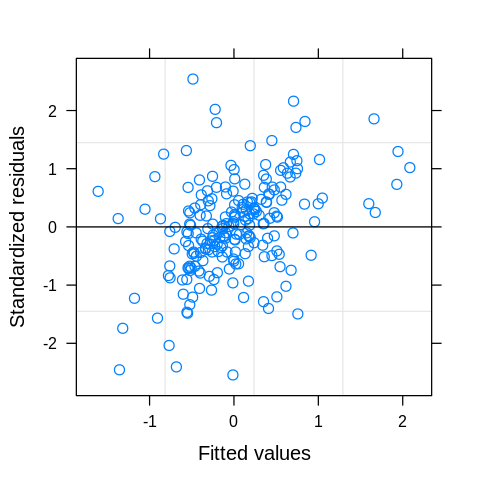

In [7]:
options(repr.plot.width = 4, repr.plot.height = 4)
plot(mm_yield)

In [8]:
rsq(y = data_yield$yield_rel,
    y_hat = predict(mm_yield))

[1] 0.4821272

In [9]:
rsq(y = data_yield$yield_rel,
    y_hat = predict(mm_yield, level = 0))

[1] 0.06723136

The R² is very low without the random effect. 

In [10]:
mm_yield_ci <- intervals(mm_yield, which = "fixed")
mm_yield_ci

Approximate 95% confidence intervals

 Fixed effects:
                       lower        est.     upper
(Intercept)      -0.34190890 -0.06564493 0.2106190
plantbiomass_rel  0.08734704  0.19019743 0.2930478
attr(,"label")
[1] "Fixed effects:"

The intercept is unlikely to differ from 0, which means that no difference from control in plant biomass was likely associated with no difference from control in yield. Also, data were likely sample from a distribution where the slope is not null, with 0.17 +/- 0.12 additional t/ha for each additional g, at the 95% level. However, the yield gain is marginal and uncertain. For example, a gain in 1 g was associated with a gain of 0.17 t/ha +/- 0.12 t/ha.

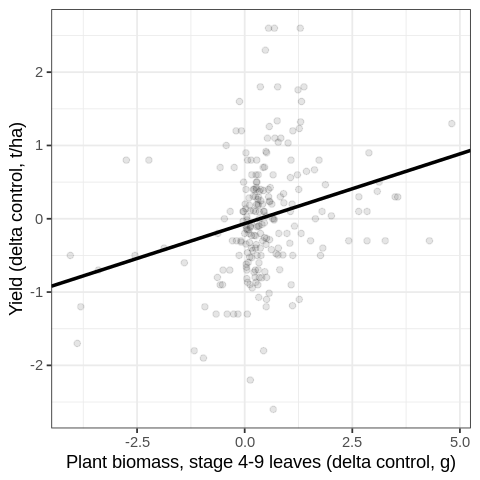

In [11]:
gg_yield <- ggplot(data = data_yield, 
       mapping = aes(x = plantbiomass_rel, y = yield_rel)) +
  geom_point(alpha = 0.1) +
  geom_abline(aes(slope = fixef(mm_yield)[2],
                  intercept = fixef(mm_yield)[1]),
              lwd = 1) +
  labs(x = "Plant biomass, stage 4-9 leaves (delta control, g)",
       y= "Yield (delta control, t/ha)") +
  theme_bw()
gg_yield

## Effect of starting biomass on **grain density**

Before running the mixed model, we clean our data set.

- Year 2000 was characterized with extreme weather events affecting crop performance. Because the following analysis don't take into account weather variables, we removed year 2000 from the analyses of this section. 
- We remove outlier relative starting biomasses greater than 5 g.
- We prepare our data by isolating the variables we need and removing lines containing `NA`s. 

In [12]:
data_dens <- data_rs %>%
  filter(plantbiomass_rel < 5 & Year != 2000) %>%
  select(ID, Year, graindensity_rel, plantbiomass_rel) %>%
  mutate(Year = factor(Year)) %>%
  drop_na() %>%
  droplevels()

The mixed model has a random effect where ID is nested in year.

In [13]:
mm_dens <- lme(graindensity_rel ~ plantbiomass_rel,
               random = ~ 1|Year/ID,
               data = data_dens)

Model's statistics.

In [14]:
summary(mm_dens)

Linear mixed-effects model fit by REML
 Data: data_dens 
       AIC      BIC    logLik
  1477.429 1494.188 -733.7144

Random effects:
 Formula: ~1 | Year
        (Intercept)
StdDev:   0.5909417

 Formula: ~1 | ID %in% Year
        (Intercept) Residual
StdDev:    7.672147 4.836554

Fixed effects: graindensity_rel ~ plantbiomass_rel 
                     Value Std.Error  DF  t-value p-value
(Intercept)      0.4863276 0.8937763 114 0.544127  0.5874
plantbiomass_rel 2.0209229 0.6202635  93 3.258168  0.0016
 Correlation: 
                 (Intr)
plantbiomass_rel -0.278

Standardized Within-Group Residuals:
        Min          Q1         Med          Q3         Max 
-2.46439787 -0.41518603 -0.01265123  0.45394057  2.10281109 

Number of Observations: 213
Number of Groups: 
        Year ID %in% Year 
           5          119 

Model residuals.

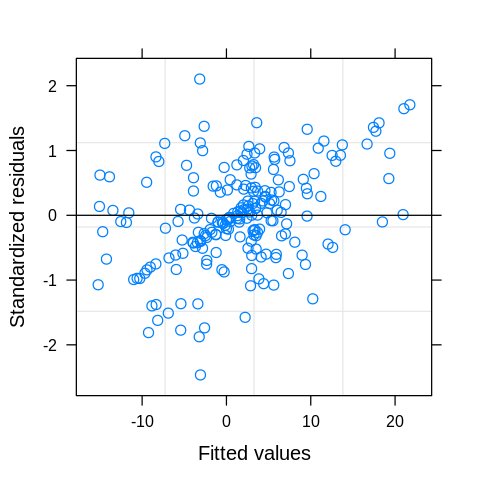

In [15]:
plot(mm_dens)

In [16]:
rsq(y = data_dens$graindensity_rel,
    y_hat = predict(mm_dens))

[1] 0.6110671

In [17]:
rsq(y = data_dens$graindensity_rel,
    y_hat = predict(mm_dens, level = 0))

[1] 0.05285881

The R² is very low without the random effect. 

In [18]:
mm_dens_ci <- intervals(mm_dens, which = "fixed")
mm_dens_ci

Approximate 95% confidence intervals

 Fixed effects:
                      lower      est.    upper
(Intercept)      -1.2842364 0.4863276 2.256892
plantbiomass_rel  0.7892025 2.0209229 3.252643
attr(,"label")
[1] "Fixed effects:"

The intercept is unlikely to differ from 0, which means that no difference from control in plant biomass was likely associated with no difference from control in density. Also, data were likely sample from a distribution where the slope is not null, although uncertain with 1.37 +/- 1.16 additional g/L for each additionnal g, at the 95% level. The density gain is marginal and uncertain.

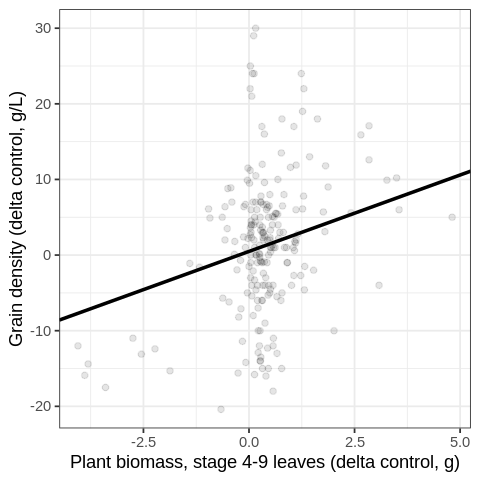

In [19]:
gg_density <- ggplot(data = data_dens, 
                     mapping = aes(x = plantbiomass_rel, y = graindensity_rel)) +
  geom_point(alpha = 0.1) +
  geom_abline(aes(slope = fixef(mm_dens)[2],
                  intercept = fixef(mm_dens)[1]),
              lwd = 1) +
  labs(x = "Plant biomass, stage 4-9 leaves (delta control, g)",
       y= "Grain density (delta control, g/L)") +
  theme_bw()
gg_density

## Effect of starting biomass on **grain moisuture**

Before running the mixed model, we clean our data set.

- Year 2000 was characterized with extreme weather events affecting crop performance. Because the following analysis don't take into account weather variables, we removed year 2000 from the analyses of this section. 
- We remove outlier relative starting bomasses greater than 5 g.
- We prepare our data by isolating the variables we need and removing lines containing `NA`s. 

In [20]:
data_moist <- data_rs %>%
  filter(plantbiomass_rel < 5 & Year != 2000) %>%
  select(ID, Year, grainmoisture_rel, plantbiomass_rel) %>%
  mutate(Year = factor(Year)) %>%
  drop_na() %>%
  droplevels()

The mixed model has a random effect where ID is nested in year.

In [21]:
mm_moist <- lme(grainmoisture_rel ~ plantbiomass_rel,
                random = ~ 1|Year/ID,
                data = data_moist)

Model's statistics.

In [22]:
summary(mm_moist)

Linear mixed-effects model fit by REML
 Data: data_moist 
       AIC      BIC   logLik
  808.7779 825.5372 -399.389

Random effects:
 Formula: ~1 | Year
        (Intercept)
StdDev:    0.712543

 Formula: ~1 | ID %in% Year
        (Intercept) Residual
StdDev:     1.12936 1.196436

Fixed effects: grainmoisture_rel ~ plantbiomass_rel 
                      Value Std.Error  DF    t-value p-value
(Intercept)      -0.2436202 0.3726955 114 -0.6536708  0.5146
plantbiomass_rel -0.3852601 0.1235629  93 -3.1179263  0.0024
 Correlation: 
                 (Intr)
plantbiomass_rel -0.11 

Standardized Within-Group Residuals:
        Min          Q1         Med          Q3         Max 
-2.80716581 -0.44004843  0.02366551  0.40206610  4.05114799 

Number of Observations: 213
Number of Groups: 
        Year ID %in% Year 
           5          119 

Model residuals.

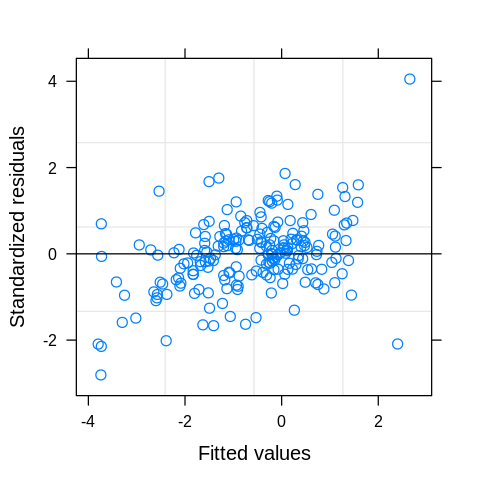

In [23]:
plot(mm_moist)

In [24]:
rsq(y = data_moist$grainmoisture_rel,
    y_hat = predict(mm_moist))

[1] 0.4411193

In [25]:
rsq(y = data_moist$grainmoisture_rel,
    y_hat = predict(mm_moist, level = 0))

[1] 0.06532438

The R² is very low without the random effect. 

In [26]:
mm_moist_ci <- intervals(mm_moist, which = "fixed")
mm_moist_ci

Approximate 95% confidence intervals

 Fixed effects:
                      lower       est.      upper
(Intercept)      -0.9819271 -0.2436202  0.4946868
plantbiomass_rel -0.6306317 -0.3852601 -0.1398886
attr(,"label")
[1] "Fixed effects:"

The intercept is unlikely to differ from 0, which means that no difference from control in plant biomass was likely associated with no difference from control in moisture. Also, data were likely sample from a distribution where the slope is not null, with -0.54 +/- 0.27 % for each additionnal g, at the 95% level. However, the moisture loss is marginal, with a 0.54% less water content if starting biomass is increased by 1 g.

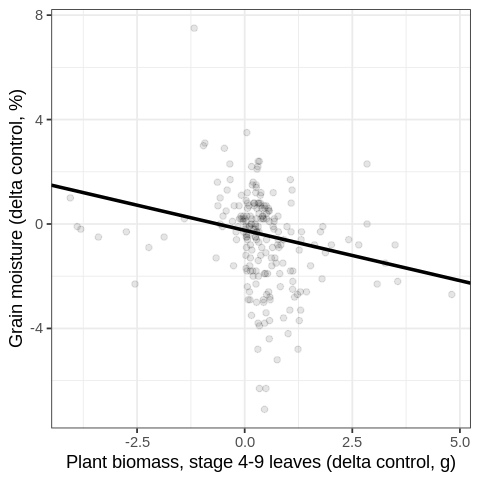

In [27]:
gg_moisture <- ggplot(data = data_moist,
                      mapping = aes(x = plantbiomass_rel, y = grainmoisture_rel)) +
  geom_point(alpha = 0.1) +
  geom_abline(aes(slope = fixef(mm_moist)[2],
                  intercept = fixef(mm_moist)[1]),
              lwd = 1) +
  labs(x = "Plant biomass, stage 4-9 leaves (delta control, g)",
       y= "Grain moisture (delta control, %)") +
  theme_bw()
gg_moisture

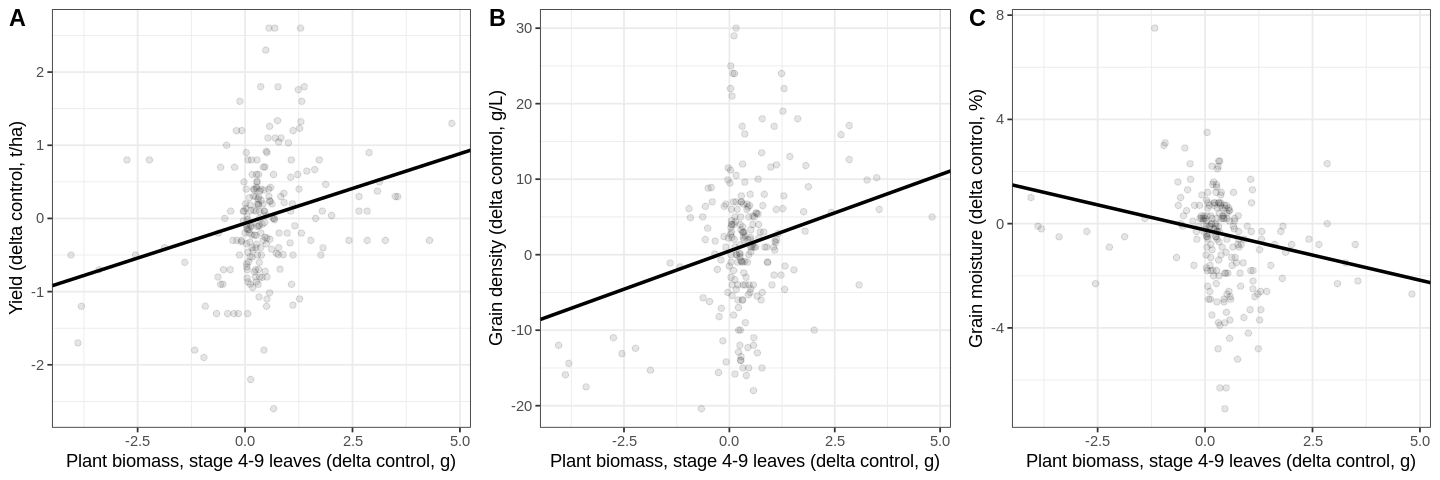

In [28]:
options(repr.plot.width = 12, repr.plot.height = 4)
plot_grid(gg_yield, gg_density, gg_moisture, ncol = 3, labels = c("A", "B", "C"))
ggsave("images/early-plant-growth.png", height=4, width=12, dpi=300)